### Imports

In [1]:
import functools as ft
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from bagpy import bagreader
from pathlib import Path
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

from utils import plot_signal, unpack_servo_data, unpack_ang_vel_data, calculate_mean_power

### Constants

In [2]:
DATA_DIR = Path('../data/train_set/csv/')
OLD = False

# Sinlge run

### Directories

In [3]:
bag_dir = '../data/train_set/fixed/1_Panele/4W/R1/45deg/T1/2023-01-05-18-09-29'
# bag_dir = '../data/train_set/fixed/1_Panele/6W/R1/45deg/circlesT1/panels_1_2023-07-17-14-25-00'
# bag_dir = '../data/train_set/fixed/2_Wykladzina_czarna/4W/R1/45deg/T1/2023-01-10-16-43-04'
# bag_dir = '../data/train_set/fixed/2_Wykladzina_czarna/6W/R1/45deg/circlesT1/blackCarpet_1_2023-07-17-11-31-44'
# bag_dir = '../data/train_set/fixed/3_Wykladzina_jasna/4W/R1/45deg/T1/2023-01-12-13-33-06'
# bag_dir = '../data/train_set/fixed/3_Wykladzina_jasna/6W/R1/45deg/circlesT1/brightCarpet_1_2023-07-17-11-01-46'
# bag_dir = '../data/train_set/fixed/4_Trawa/4W/R1/45deg/T1/2023-01-14-12-38-55'
# bag_dir = '../data/train_set/fixed/4_Trawa/6W/R1/45deg/circlesT1/grass_1_2023-07-17-13-04-50'
# bag_dir = '../data/train_set/fixed/5_Spienione_PCV/4W/R1/45deg/T1/2023-01-14-15-03-48'
# bag_dir = '../data/train_set/fixed/5_Spienione_PCV/6W/R1/45deg/circlesT1/QR_1_2023-07-17-12-31-24'
# bag_dir = '../data/train_set/fixed/6_Linoleum/4W/R1/45deg/T1/2023-01-14-16-00-17'
# bag_dir = '../data/train_set/fixed/6_Linoleum/6W/R1/45deg/circlesT1/Linoleum_1_2023-07-17-10-22-55'
# bag_dir = '../data/train_set/fixed/7_Plytki_w_sali/4W/R1/45deg/T1/2023-01-15-15-47-30'
# bag_dir = '../data/train_set/fixed/7_Plytki_w_sali/6W/R1/45deg/circlesT1/tiles_1_2023-07-13-16-48-17'
# bag_dir = '../data/train_set/fixed/8_Pusta_plyta/4W/R1/45deg/T1/2023-01-15-13-23-37'
# bag_dir = '../data/train_set/fixed/8_Pusta_plyta/6W/R1/45deg/circlesT1/OSB_1_2023-07-17-12-00-56'
# bag_dir = '../data/train_set/fixed/9_podklady/4W/R1/45deg/T1/2023-01-15-14-12-52'
# bag_dir = '../data/train_set/fixed/9_podklady/6W/R1/45deg/circlesT1/gray_1_2023-07-13-18-06-16'
# bag_dir = '../data/train_set/fixed/10_Mata_ukladana/4W/R1/45deg/T1/2023-01-15-16-41-51'
# bag_dir = '../data/train_set/fixed/10_Mata_ukladana/6W/R1/45deg/circlesT1/blueFoam_1_2023-07-14-08-30-27'

if '4W' in bag_dir:
    OLD = True

### Load data from csv

In [4]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/train_set/fixed/1_Panele/4W/R1/45deg/T1/2023-01-05-18-09-29 already exists. Not creating.


In [5]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/Servo_data,kin_odom_msg/Measurements,647,20.771851
1,/cmd_vel,geometry_msgs/Twist,2123,76.785003
2,/filter/quaternion,geometry_msgs/QuaternionStamped,3193,338.223047
3,/imu/acceleration,geometry_msgs/Vector3Stamped,3193,339.537278
4,/imu/angular_velocity,geometry_msgs/Vector3Stamped,3193,339.936297
5,/imu/data,sensor_msgs/Imu,3193,340.267229
6,/imu/mag,geometry_msgs/Vector3Stamped,3193,339.358712
7,/imu/time_ref,sensor_msgs/TimeReference,3193,365.341579
8,/odom,nav_msgs/Odometry,1622,54.226405
9,/rosout,rosgraph_msgs/Log,25,18275.834423


In [6]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

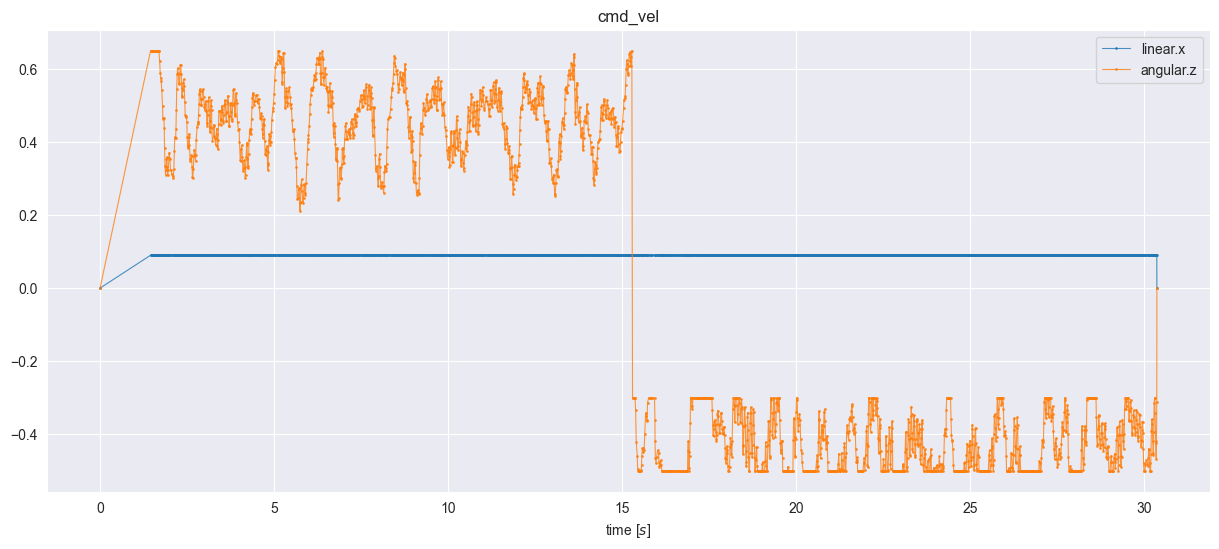

In [7]:
key = 'cmd_vel'
cmd_vel = topic_data[key]
if '4W' in bag_dir:
    cols = ['linear.x', 'angular.z']
else:
    cols = ['twist.linear.x', 'twist.angular.z']
plot_signal(cmd_vel, cols, title=key)

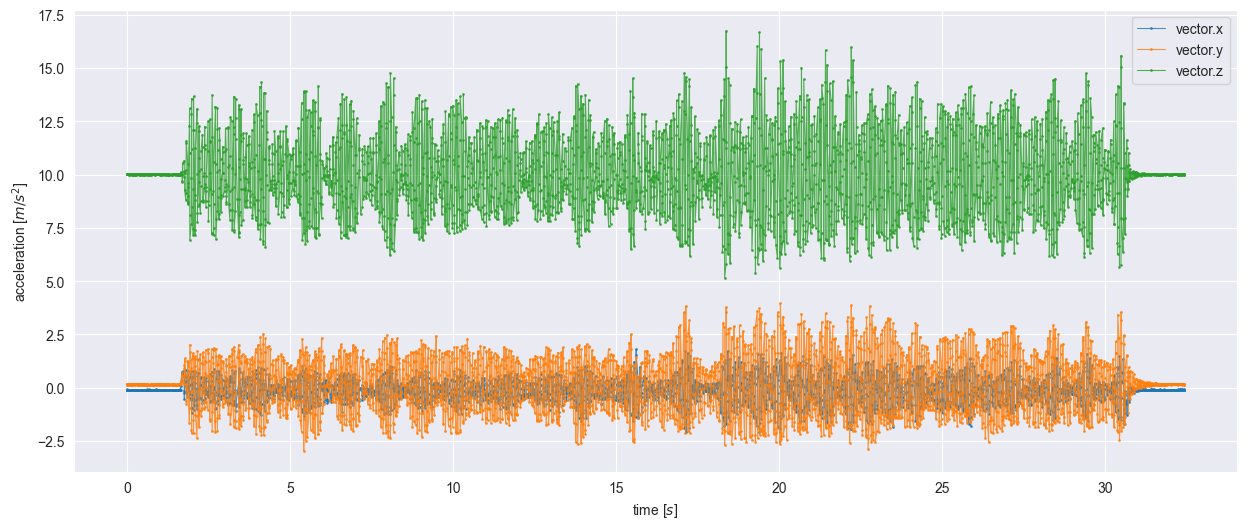

In [8]:
key = 'imu-acceleration'
imu_acceleration = topic_data[key]
cols = ['vector.x', 'vector.y', 'vector.z']
plot_signal(imu_acceleration, cols, y_label='acceleration [$m/s^2$]')

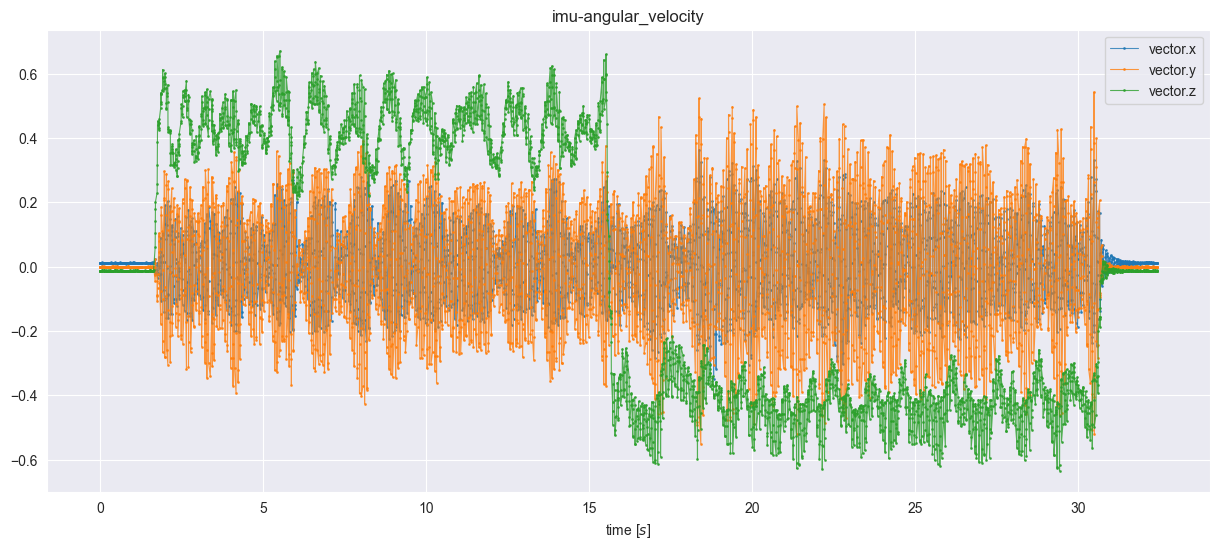

In [9]:
key = 'imu-angular_velocity'
imu_angular_velocity = topic_data[key]
cols = ['vector.x', 'vector.y', 'vector.z']
plot_signal(imu_angular_velocity, cols, title=key)

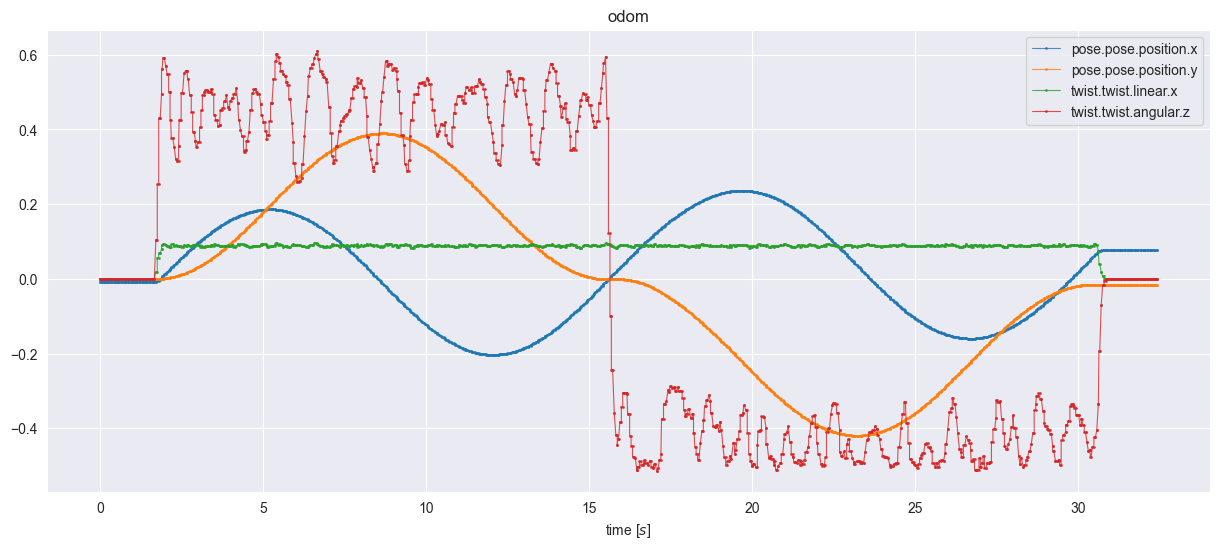

In [10]:
key = 'odom'
odom = topic_data[key]
cols = ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']
plot_signal(odom, cols, title=key)

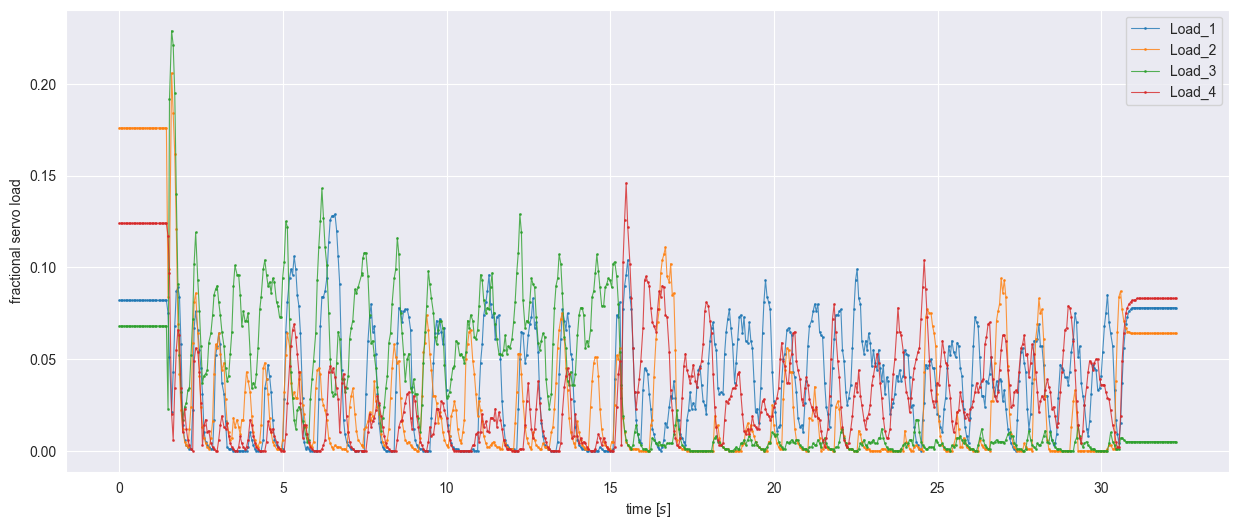

In [11]:
key = 'Servo_data'
servo_data = topic_data[key]
servo_data.rename(columns={"values": "load"}, inplace=True)
servo_data = unpack_servo_data(servo_data)
cols = servo_data.columns[1:]
plot_signal(servo_data, cols, y_label='fractional servo load')

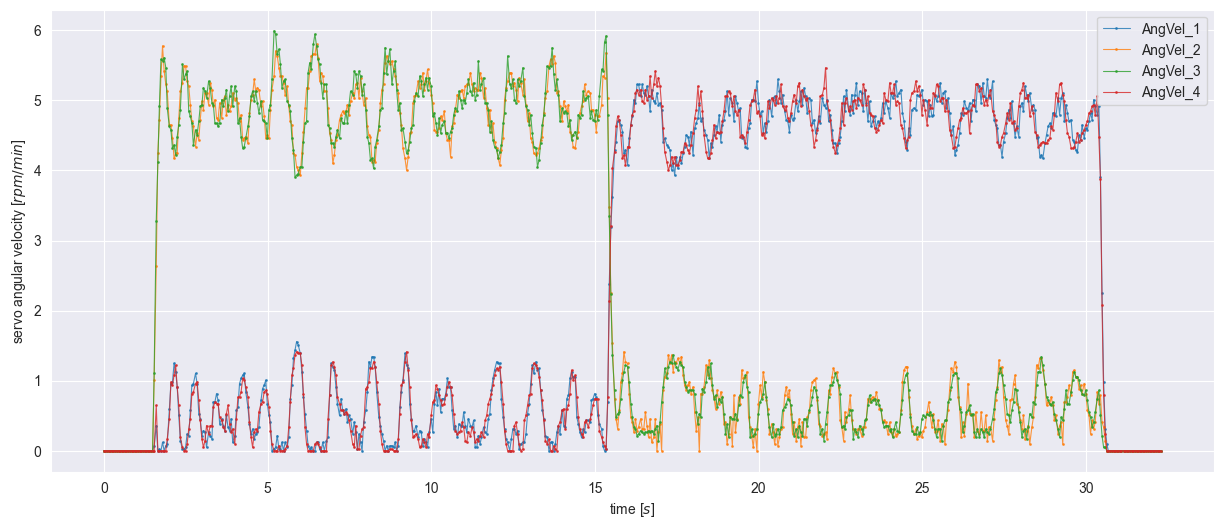

In [12]:
key = 'wheel_feedback'
wheel_feedback = topic_data[key]
wheel_feedback.rename(columns={"values": "angular_velocity"}, inplace=True)
wheel_feedback = unpack_ang_vel_data(wheel_feedback)
cols = wheel_feedback.columns[1:]
plot_signal(wheel_feedback, cols, y_label='servo angular velocity [$rpm/min$]')

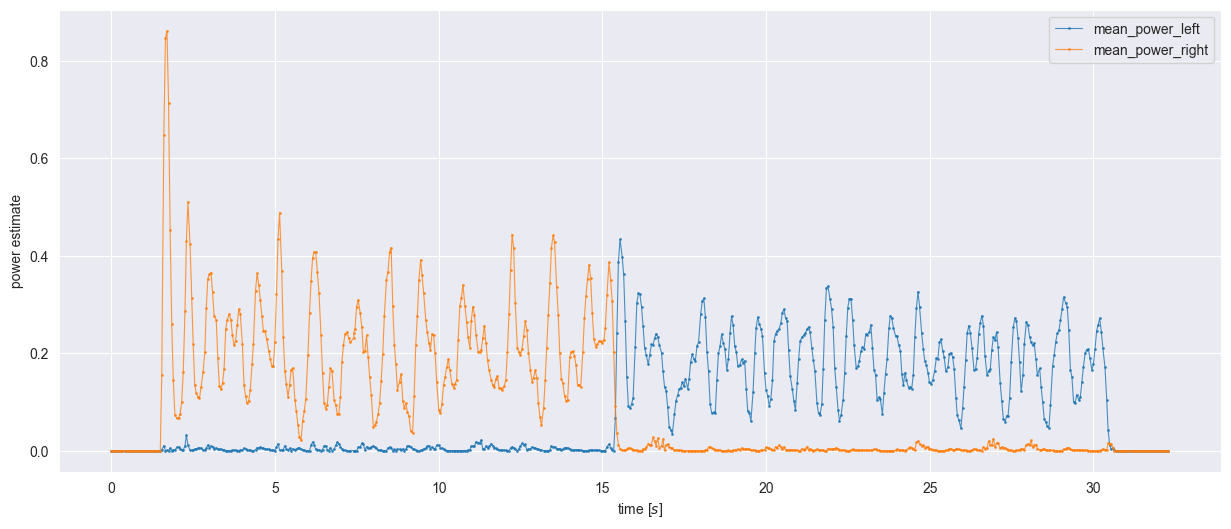

In [13]:
power = calculate_mean_power(servo_data.drop(columns=['Time']), wheel_feedback.drop(columns=['Time']), OLD)
power = pd.concat([servo_data['Time'], power], axis=1)
cols = power.columns[-2:]
plot_signal(power, cols, y_label='power estimate')

### Refine data

In [14]:
imu_data = topic_data['imu-data']

In [15]:
if '4W' in bag_dir:
    cmd_vel_refined = cmd_vel[['Time', 'linear.x', 'angular.z']]
else:
    cmd_vel_refined = cmd_vel[['Time', 'twist.linear.x', 'twist.angular.z']]
imu_acceleration_refined = imu_data[['Time', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']]
imu_angular_velocity_refined = imu_data[['Time', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']]
odom_refined = odom[['Time', 'pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']]
power_refined = power[['Time', 'mean_power_left', 'mean_power_right']]

In [16]:
dataframes = [cmd_vel_refined, imu_acceleration_refined, imu_angular_velocity_refined, odom_refined, power_refined]
dataframe = ft.reduce(lambda left, right: pd.merge(left, right, how='outer', on='Time'), dataframes)
dataframe.ffill(inplace=True)
dataframe.bfill(inplace=True)
dataframe['Time'] -= dataframe['Time'].min()
dataframe

,Time,linear.x,angular.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,pose.pose.position.x,pose.pose.position.y,twist.twist.linear.x,twist.twist.angular.z,mean_power_left,mean_power_right
0,0.000000,0.0,0.0,-0.087740,0.148083,10.012362,0.010894,-0.001115,-0.012561,-0.007998,-0.000011,0.0,0.0,0.0,0.0
1,0.006856,0.0,0.0,-0.087740,0.148083,10.012362,0.010894,-0.001115,-0.012561,-0.007998,-0.000011,0.0,0.0,0.0,0.0
2,0.010607,0.0,0.0,-0.087740,0.148083,10.012362,0.010894,-0.001115,-0.012561,-0.007998,-0.000011,0.0,0.0,0.0,0.0
3,0.014733,0.0,0.0,-0.101101,0.169184,10.026657,0.010992,-0.000723,-0.014634,-0.007998,-0.000011,0.0,0.0,0.0,0.0
4,0.019257,0.0,0.0,-0.081795,0.147502,10.007434,0.010591,-0.002728,-0.015212,-0.007998,-0.000011,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,32.423849,0.0,0.0,-0.081606,0.162881,10.025057,0.010381,-0.001451,-0.013046,0.076308,-0.016890,0.0,0.0,0.0,0.0
7580,32.424778,0.0,0.0,-0.094585,0.147586,9.991545,0.011920,0.000229,-0.012014,0.076308,-0.016890,0.0,0.0,0.0,0.0
7581,32.426941,0.0,0.0,-0.092138,0.147557,10.001794,0.011614,-0.002078,-0.012746,0.076308,-0.016890,0.0,0.0,0.0,0.0
7582,32.430028,0.0,0.0,-0.108205,0.160347,10.001320,0.012285,-0.001356,-0.013443,0.076308,-0.016890,0.0,0.0,0.0,0.0


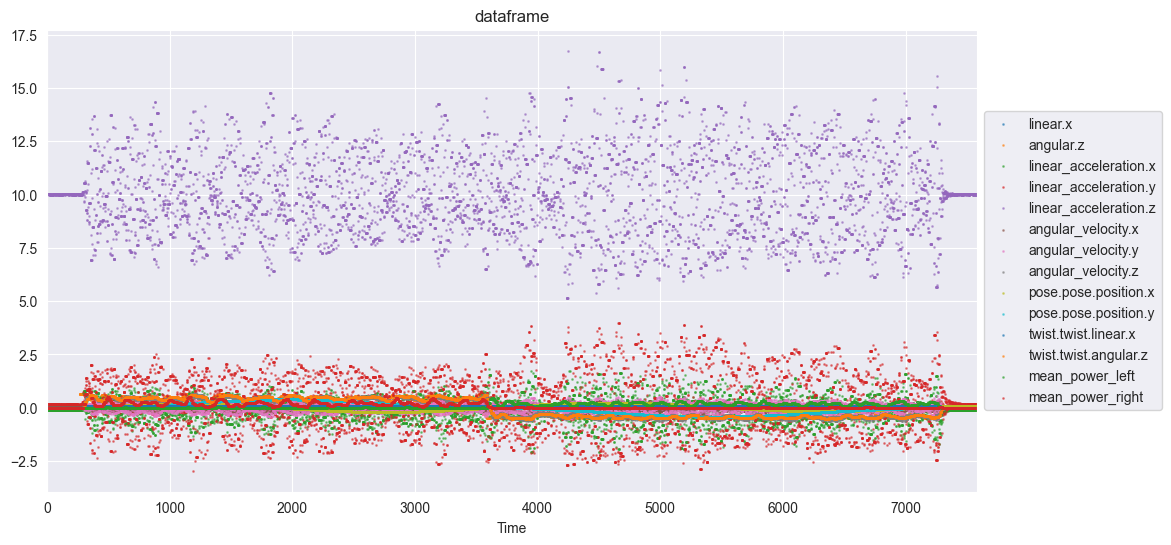

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

for column in dataframe.columns[1:]:
    ax.scatter(x=dataframe.index, y=dataframe[column], s=1, alpha=0.5, label=column)
ax.set_title('dataframe')
ax.set_xlabel('Time')
ax.set_xlim(dataframe.index[0], dataframe.index[-1])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Correlation matrix

(14.5, -0.5)

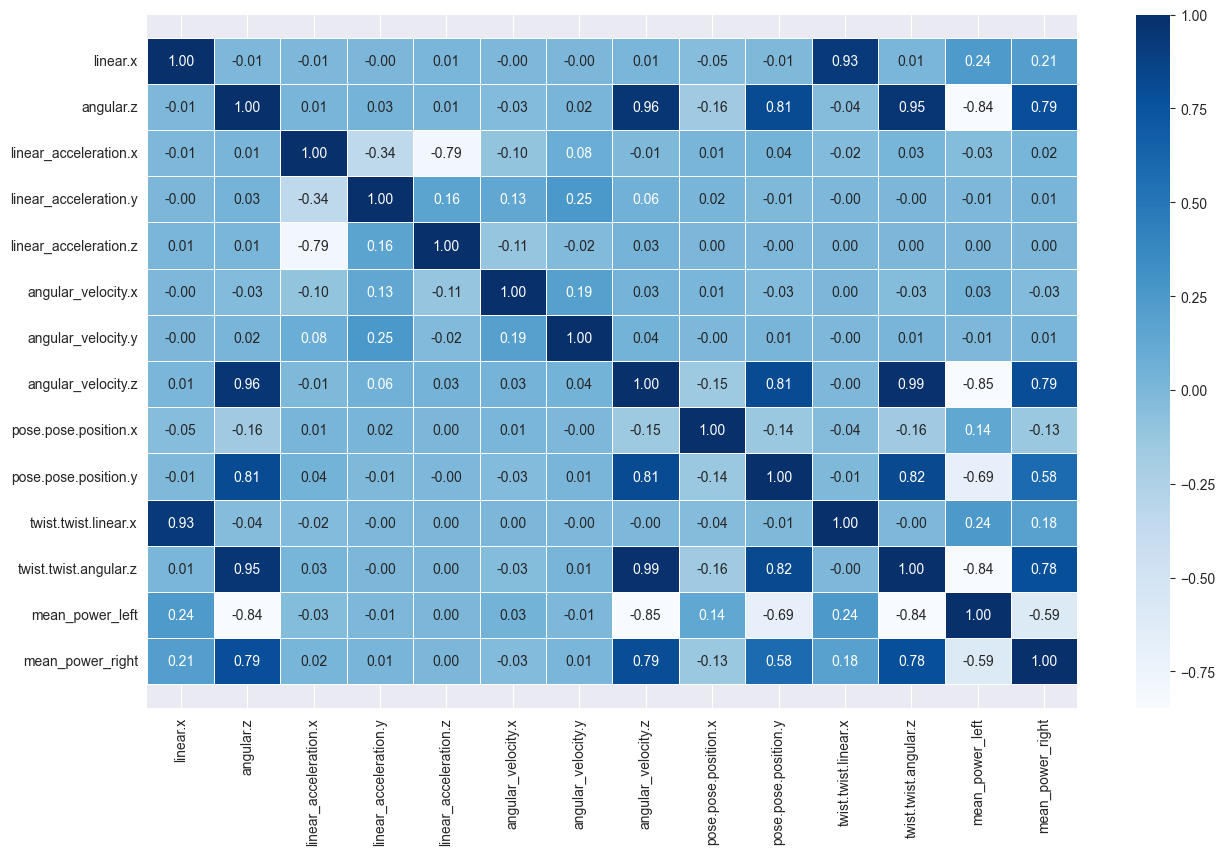

In [18]:
corr_matrix = dataframe.drop(columns=['Time']).corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Correlation visualizations

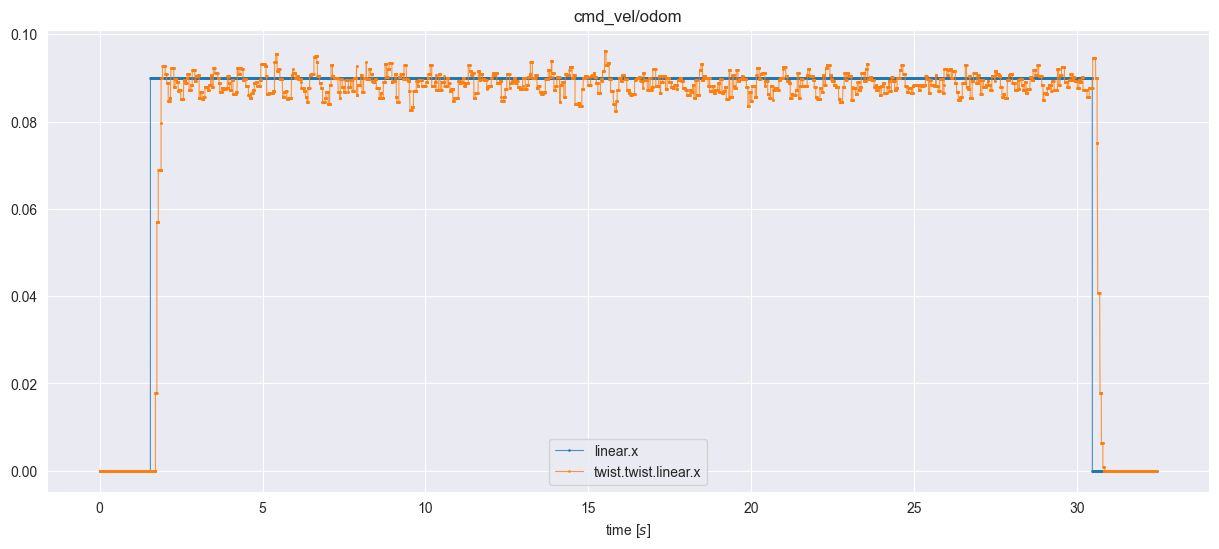

In [19]:
# cmd_vel / odom
if '4W' in bag_dir:
    cols = ['linear.x', 'twist.twist.linear.x']
else:
    cols = ['twist.linear.x', 'twist.twist.linear.x']
plot_signal(dataframe, cols, 'cmd_vel/odom')

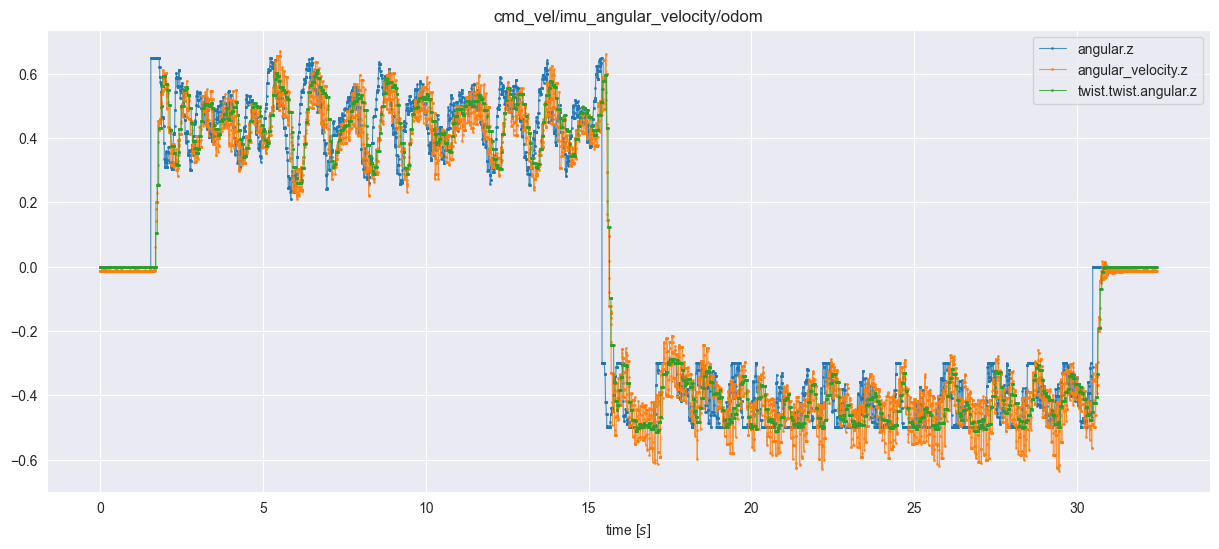

In [20]:
# cmd_vel / imu_angular_velocity / odom
if '4W' in bag_dir:
    cols = ['angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
else:
    cols = ['twist.angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
plot_signal(dataframe, cols, 'cmd_vel/imu_angular_velocity/odom')

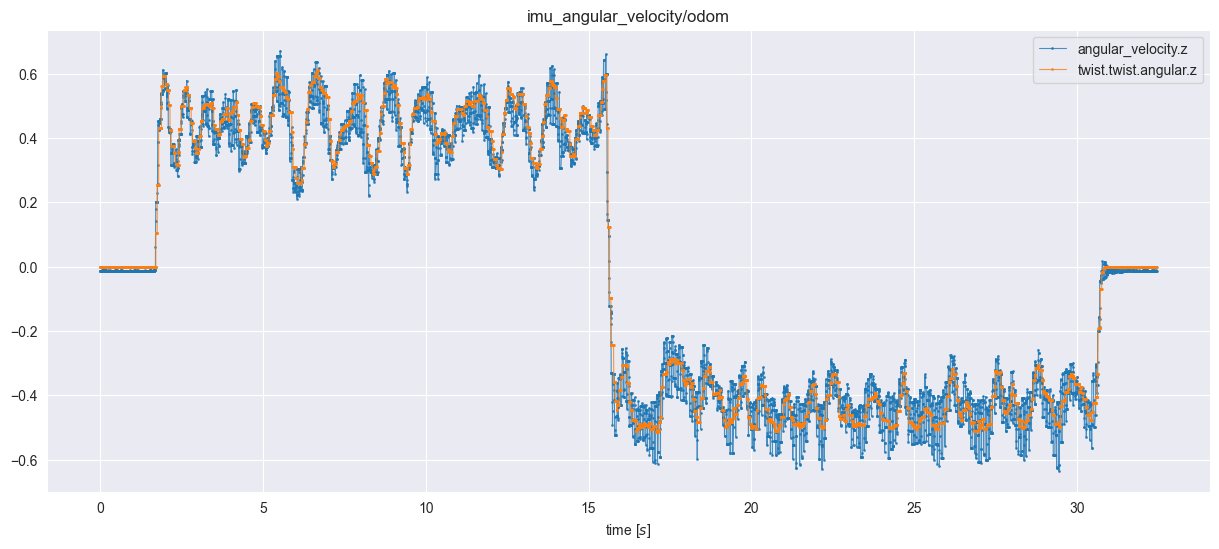

In [21]:
# imu_angular_velocity / odom
cols = ['angular_velocity.z', 'twist.twist.angular.z']
plot_signal(dataframe, cols, 'imu_angular_velocity/odom')

# Train set

In [22]:
with open('../data/train_set/labels.json') as fp:
    labels = json.load(fp)

In [23]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1' and 'T1' in values['trajectory']]

In [24]:
files = pd.Series([run[0] for run in dataset], name='bag_name')
y = [run[1] for run in dataset]

In [25]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [26]:
X = [pd.read_csv(sample, index_col=[0])[[
    'Time',
    'linear_acceleration.x',
    'linear_acceleration.y',
    'linear_acceleration.z',
    'angular_velocity.x',
    'angular_velocity.y',
    'angular_velocity.z',
    'mean_power_left',
    'mean_power_right',
]] for sample in files]

for df, label in zip(X, y):
    df['target'] = label

sampling_freqs = [len(file) / file['Time'].max() for file in X]
print(np.mean(sampling_freqs))
print(np.std(sampling_freqs))

X = pd.concat(X, axis=0)

146.43119410417728
11.462349490594288


In [27]:
pd.DataFrame(mutual_info_classif(X.drop(columns=['Time', 'target']), X['target']).reshape(1, -1), columns=X.columns[1:-1], index=['Mutual Information'])

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,mean_power_left,mean_power_right
Mutual Information,0.696232,0.72182,0.713131,0.690152,0.749082,0.749989,0.956489,1.042169


In [28]:
pd.DataFrame(mutual_info_regression(X.drop(columns=['Time', 'target']), X['target']).reshape(1, -1), columns=X.columns[1:-1], index=['Mutual Information'])

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,mean_power_left,mean_power_right
Mutual Information,0.696379,0.721913,0.713178,0.690266,0.749152,0.750227,0.954678,1.037191


(8.5, -0.5)

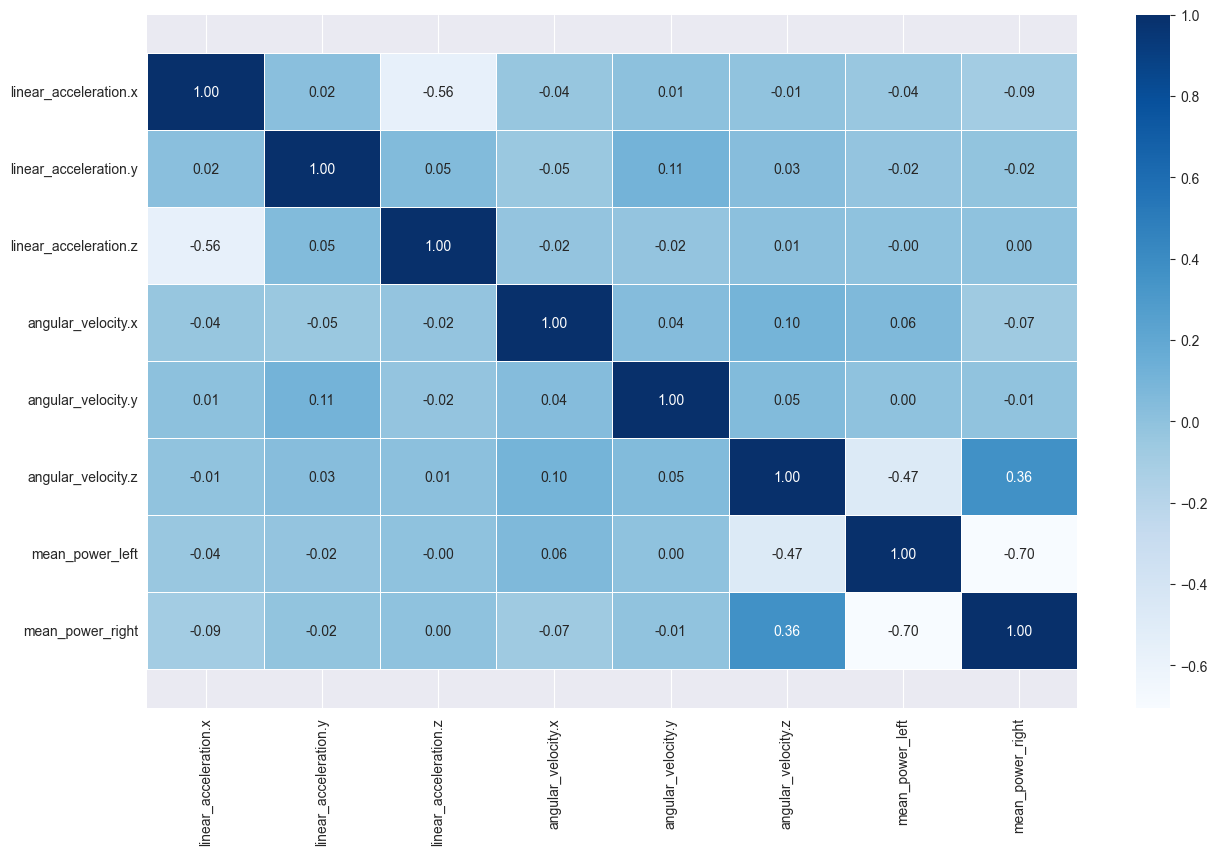

In [29]:
corr_matrix = X.drop(columns=['Time', 'target']).corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
sns.pairplot(X)

In [ ]:
g = sns.PairGrid(X, hue='target', diag_sharey=False, corner=True)
g.map_lower(sns.histplot)
g.map_diag(sns.histplot)
g.add_legend()

# Test set

### Directories

In [83]:
bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza'
# bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza_2'
# bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_1'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_2'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_1'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_2'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CW_1'

OLD = False

### Load data from csv

In [84]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/test_set/bags/06-05-4-kola-3-podloza already exists. Not creating.


In [85]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/Servo_data,universal_robot_msg/Measurements,1089,15.627151
1,/cmd_vel,geometry_msgs/TwistStamped,191,19.999161
2,/imu/data,sensor_msgs/Imu,6700,3945.723424
3,/odom,nav_msgs/Odometry,1090,15.628636
4,/velocity,universal_robot_msg/VelocityWheel,191,19.998207
5,/wheel_feedback,universal_robot_msg/VelocityWheel,1090,15.627355


In [86]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

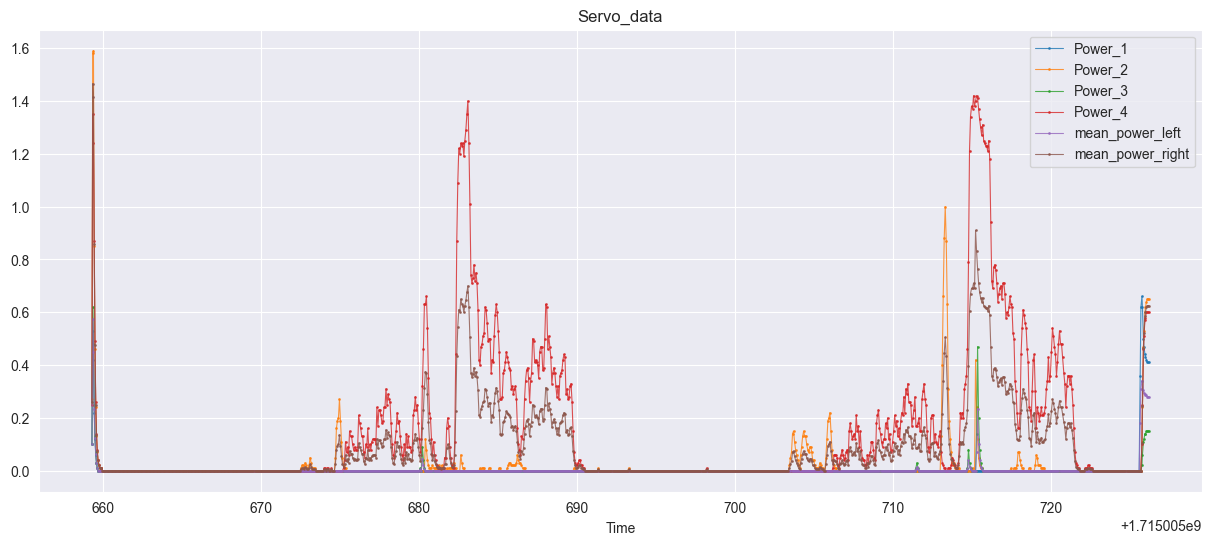

In [87]:
key = 'Servo_data'
servo_data = topic_data[key]
servo_data = unpack_servo_data(servo_data, OLD)
cols = servo_data.columns[1:].drop(['mean_power'])
plot_signal(servo_data, cols, key)

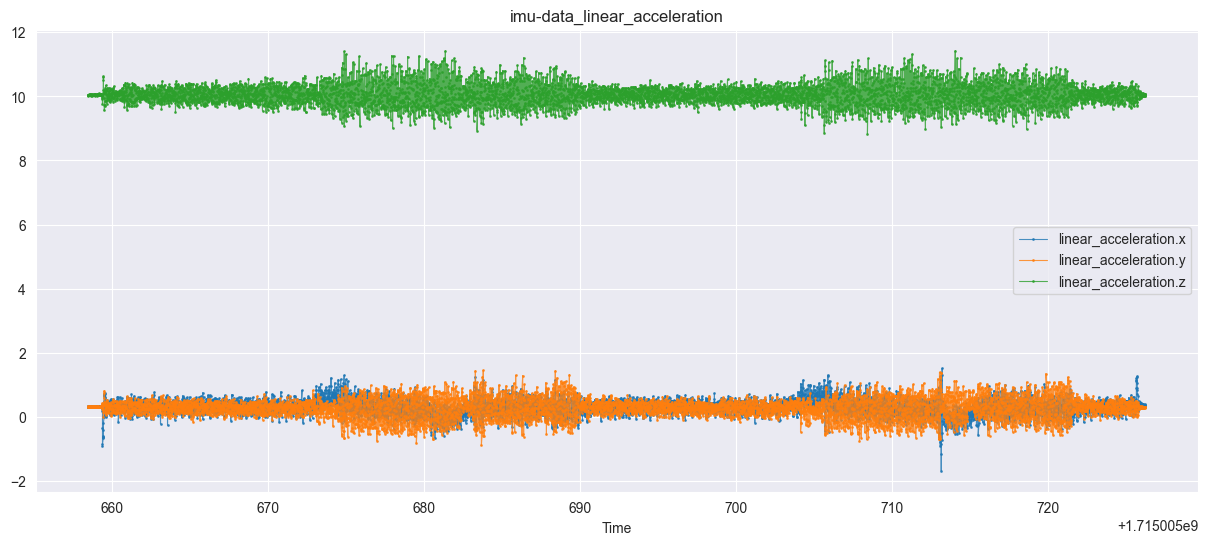

In [88]:
key = 'imu-data'
imu_data = topic_data[key]
cols = ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
plot_signal(imu_data, cols, key + '_linear_acceleration')

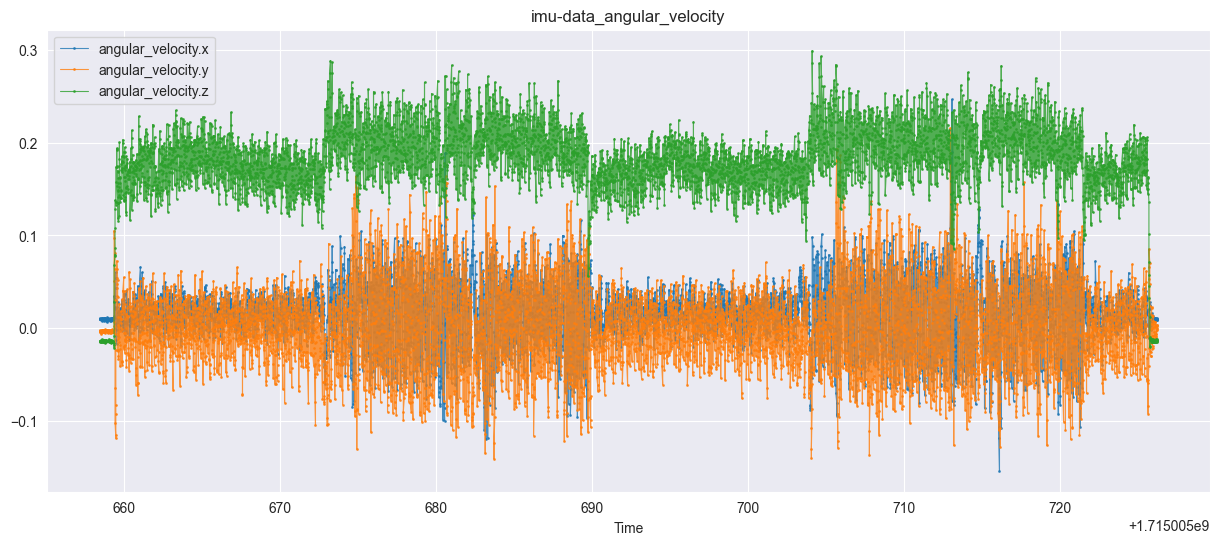

In [89]:
cols = ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']
plot_signal(imu_data, cols, key + '_angular_velocity')